# Snow Cover
env: `phd_v3`

Voir : https://github.com/mickaellalande/PhD/blob/master/CICLAD/Himalaya/CMIP6_IPSL_bias/Snow%20cover.ipynb pour plus de détails

Papier forçages LS3MIP : https://gmd.copernicus.org/articles/9/2809/2016/

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle # For rectangles
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats # For linregress (trends)
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, '../../../') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]
Virtual memory usage - total: 252 GB / available: 162 GB / percent used: 35.8 %


# Load model data

In [2]:
# Define period
period = slice('1981','2014')

# Define zone
latlim=(10,50)
lonlim=(60,110)

# Model
institute = 'IPSL'
model = 'IPSL-CM6A-LR'
var = 'snc'
if var in ['tas', 'pr']:
    table = 'Amon'
elif var in ['snc']:
    table = 'LImon'
    
var_label = 'Snow cover extent [%]'
var_label_trends = 'Snow cover extent trends [%/dec]'
var_label_bias = 'Snow cover bias [%]'
cmap='viridis'
levels=plot.arange(0,100,10)

## Load ensemble mean

In [3]:
realization = 'ens'
# Load historical ens
experiment='historical'
da_historical = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)
# Load amip ens
experiment='amip'
da_amip = xr.open_dataarray(
    '/data/mlalande/bdd/CMIP6/CMIP/'+institute+'/'+model+'/'+experiment+'/'+realization+'/'+table+'/'+var+'/gr/latest/'+\
    var+'_'+table+'_'+model+'_'+experiment+'_'+realization+'_gr_198101-201412.nc'
)

# No ensembles for land-hist and HR
realization = 'r1i1p1f1'
# Load land-hist
da_land_hist = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]
# Load HighResMIP
da_HR = xr.open_mfdataset(
    '/bdd/CMIP6/HighResMIP/'+institute+'/IPSL-CM6A-ATM-HR/highresSST-present/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

In [4]:
realization = 'r1i1p1f1'
# Load land-hist
da_land_hist_cruNcep = xr.open_mfdataset(
    '/bdd/CMIP6/LS3MIP/'+institute+'/'+model+'/land-hist-cruNcep/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

## Load obs

### NOAA Climate Data Record (CDR) of Northern Hemisphere (NH) Snow Cover Extent (SCE), Version 1
https://data.nodc.noaa.gov/cgi-bin/iso?id=gov.noaa.ncdc:C00756

In [5]:
obs_longname = 'NOAA Climate Data Record (CDR) Version 1'
obs_name = 'NOAA CDR'

In [6]:
ds_rutger = xr.open_dataset('/data/mlalande/RUTGERS/nhsce_v01r01_19661004_20191202.nc').sel(time=period)

In [7]:
# Get the snc variable, keep only land data and convert to %
with xr.set_options(keep_attrs=True):
    obs = ds_rutger.snow_cover_extent.where(ds_rutger.land == 1)*100
    
obs.attrs['units'] = '%'

# Rename lon and lat for the regrid
obs = obs.rename({'longitude': 'lon', 'latitude': 'lat'})

# Resamble data per month (from per week)
obs = obs.resample(time='1MS').mean('time', skipna='False', keep_attrs=True)

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [8]:
# For adding NaN values outside of the grid, otherwise it puts 0 (see issue just up #15)
import scipy
def add_matrix_NaNs(regridder):
    X = regridder.weights
    M = scipy.sparse.csr_matrix(X)
    num_nonzeros = np.diff(M.indptr)
    M[num_nonzeros == 0, 0] = np.NaN
    regridder.weights = scipy.sparse.coo_matrix(M)
    return regridder

# Make the regrider
regridder_obs = xe.Regridder(obs, da_historical, 'bilinear', periodic=False, reuse_weights=True)
regridder_obs = add_matrix_NaNs(regridder_obs)
print(regridder_obs)

# Regrid the data
obs_regrid = regridder_obs(obs)

Reuse existing file: bilinear_88x88_143x144.nc


/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_88x88_143x144.nc 
Reuse pre-computed weights? True 
Input grid shape:           (88, 88) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

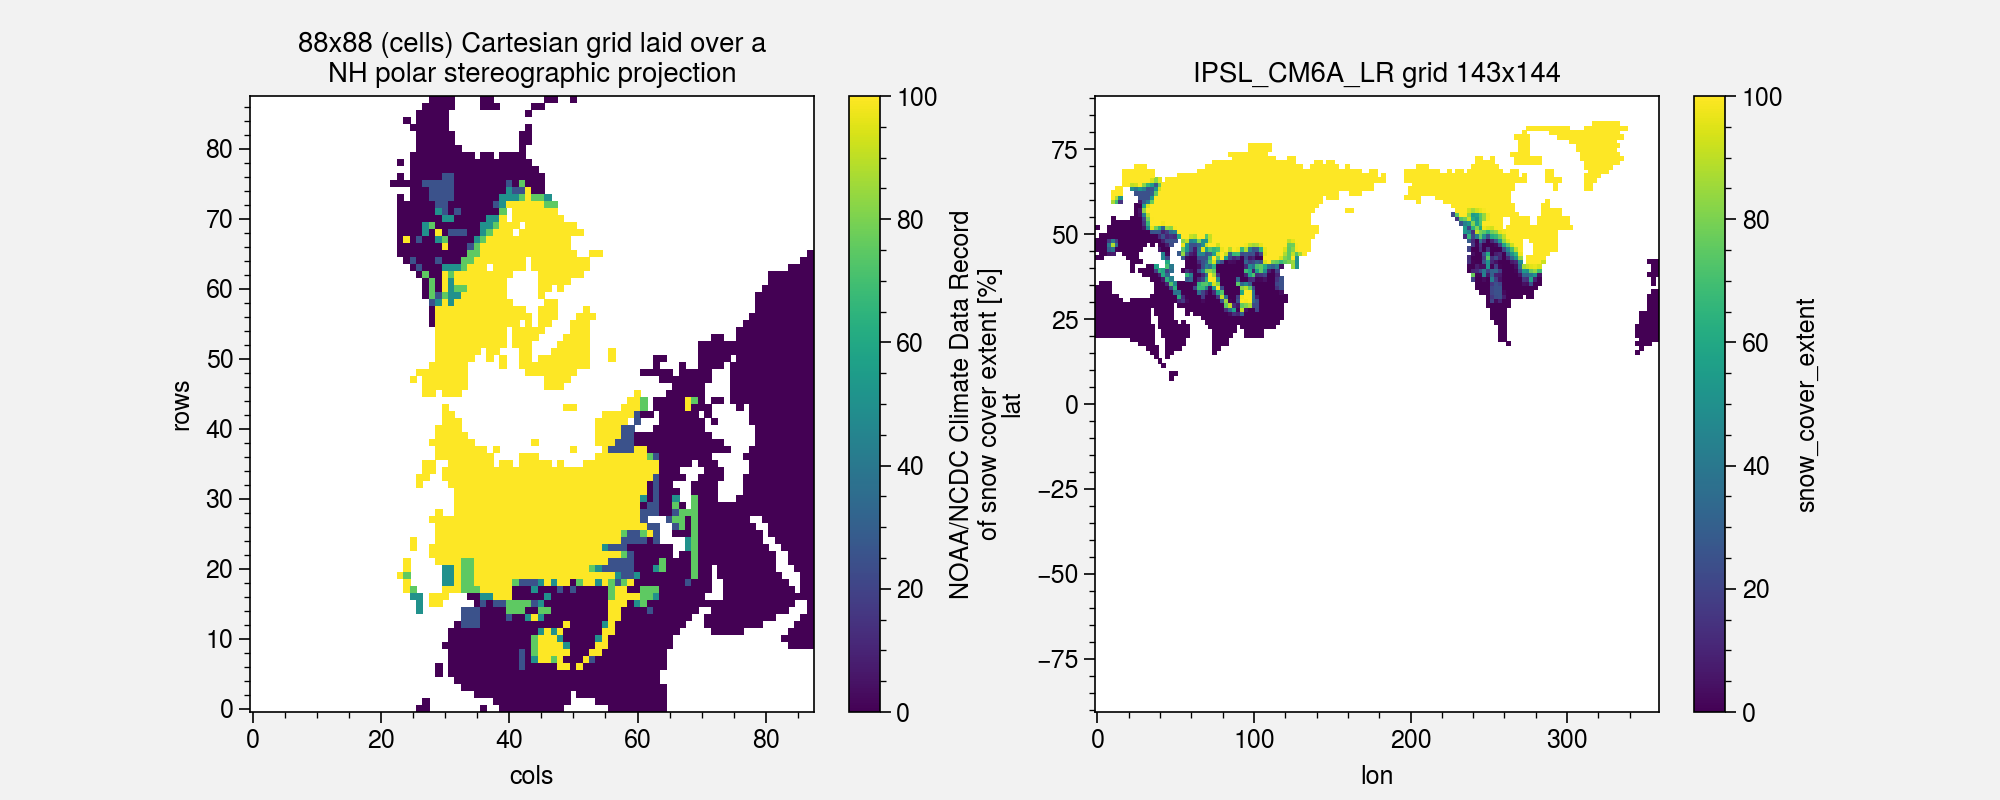

In [9]:
plt.figure(figsize=(10,4))
plt.subplot(121)
obs[0].plot()
plt.title('88x88 (cells) Cartesian grid laid over a\nNH polar stereographic projection')
plt.subplot(122)
obs_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

### Regrid HR

In [10]:
# Regrid HighResMIP
regridder_HR = xe.Regridder(da_HR, da_historical, 'bilinear', periodic=True, reuse_weights=True)
print(regridder_HR)

# Regrid the data
da_HR_regrid = regridder_HR(da_HR)

Reuse existing file: bilinear_361x512_143x144_peri.nc
xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_361x512_143x144_peri.nc 
Reuse pre-computed weights? True 
Input grid shape:           (361, 512) 
Output grid shape:          (143, 144) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      True


Text(0.5, 1.0, 'da_HR_regrid')

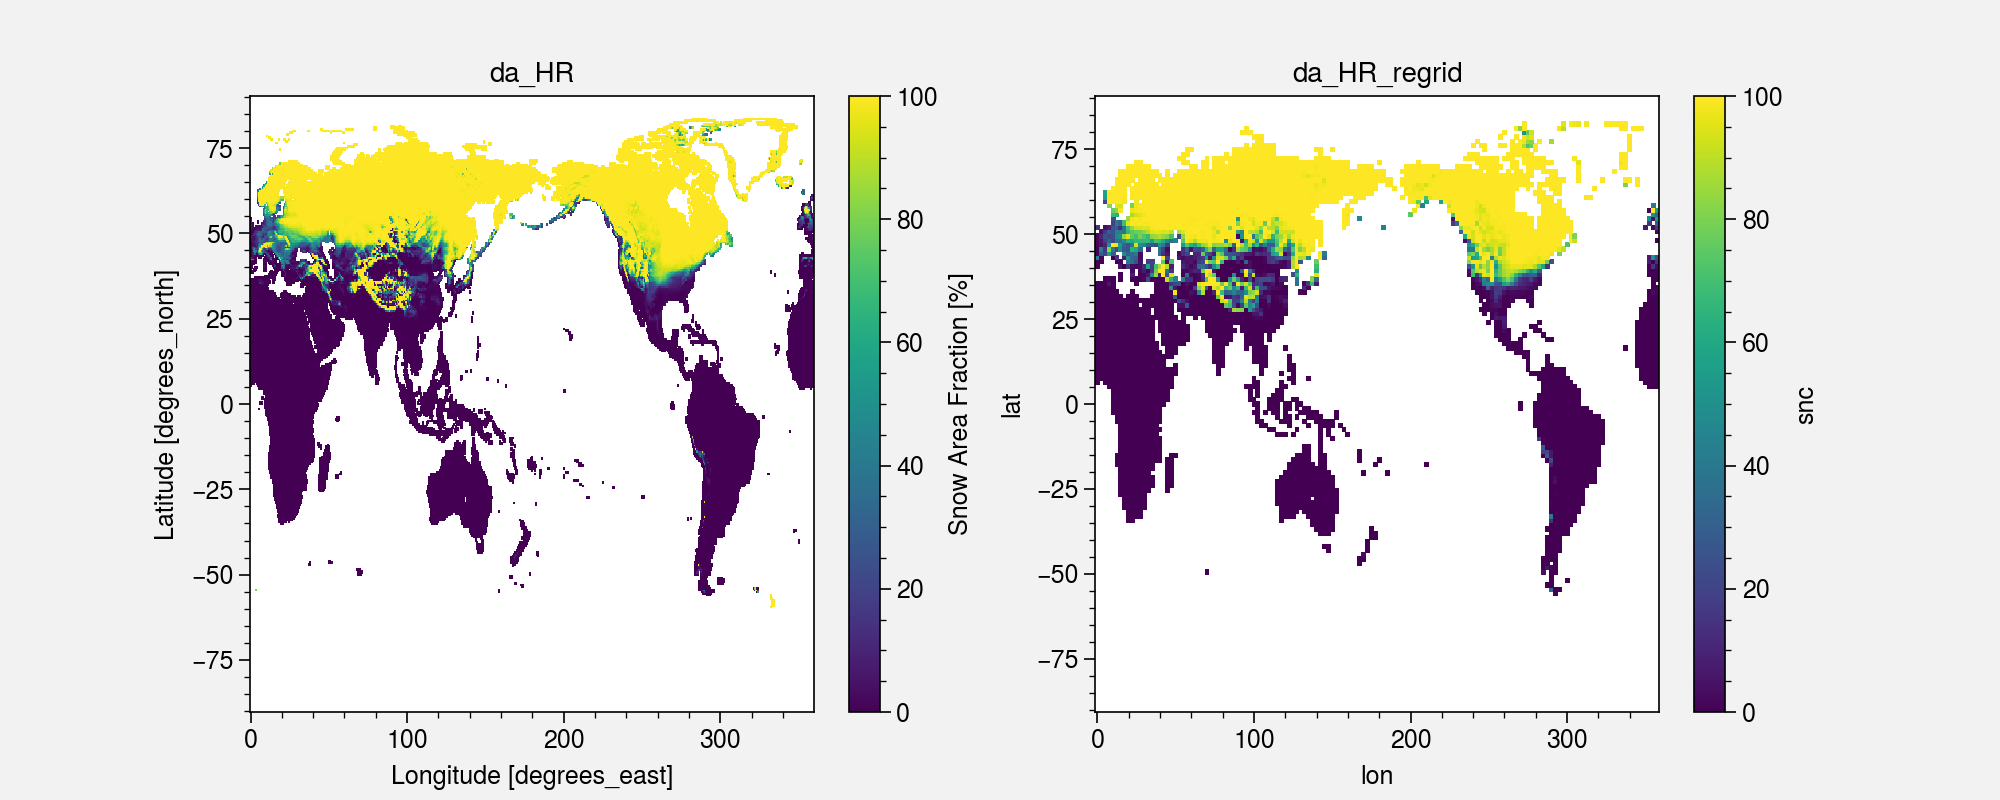

In [11]:
plt.figure(figsize=(10,4))
plt.subplot(121)
da_HR[0].plot()
plt.title('da_HR')
plt.subplot(122)
da_HR_regrid[0].plot()
plt.title('da_HR_regrid')

### ESA snow CCI AVHRR (linear interpolation 10 days maxgap)
https://github.com/mickaellalande/PhD/blob/master/local/ESA_CCI_snow/snowCCI_preprocess_AVHRR_gricad_v1.ipynb

In [12]:
root_data_path = '/data/mlalande/'
ds = xr.open_mfdataset(root_data_path+'ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly_1deg/*.nc').sel(time=period)
# Check if the time steps are ok
# np.testing.assert_equal((int(period.stop) - int(period.start) + 1)*12, ds.time.size)
# Attention il manque des mois (donc plutôt faire un groupby month avant de faire la climatologie)

snow_cci_interp = ds['scfg_interp_1deg_icefilled']
# snow_cci_interp['time'] = noaa_cdr_2.time

In [13]:
regridder = xe.Regridder(snow_cci_interp, da_historical, 'bilinear', periodic=True, reuse_weights=True)
snow_cci_interp_regrid = regridder(snow_cci_interp)

Reuse existing file: bilinear_180x360_143x144_peri.nc


Text(0.5, 1.0, 'IPSL_CM6A_LR grid 143x144')

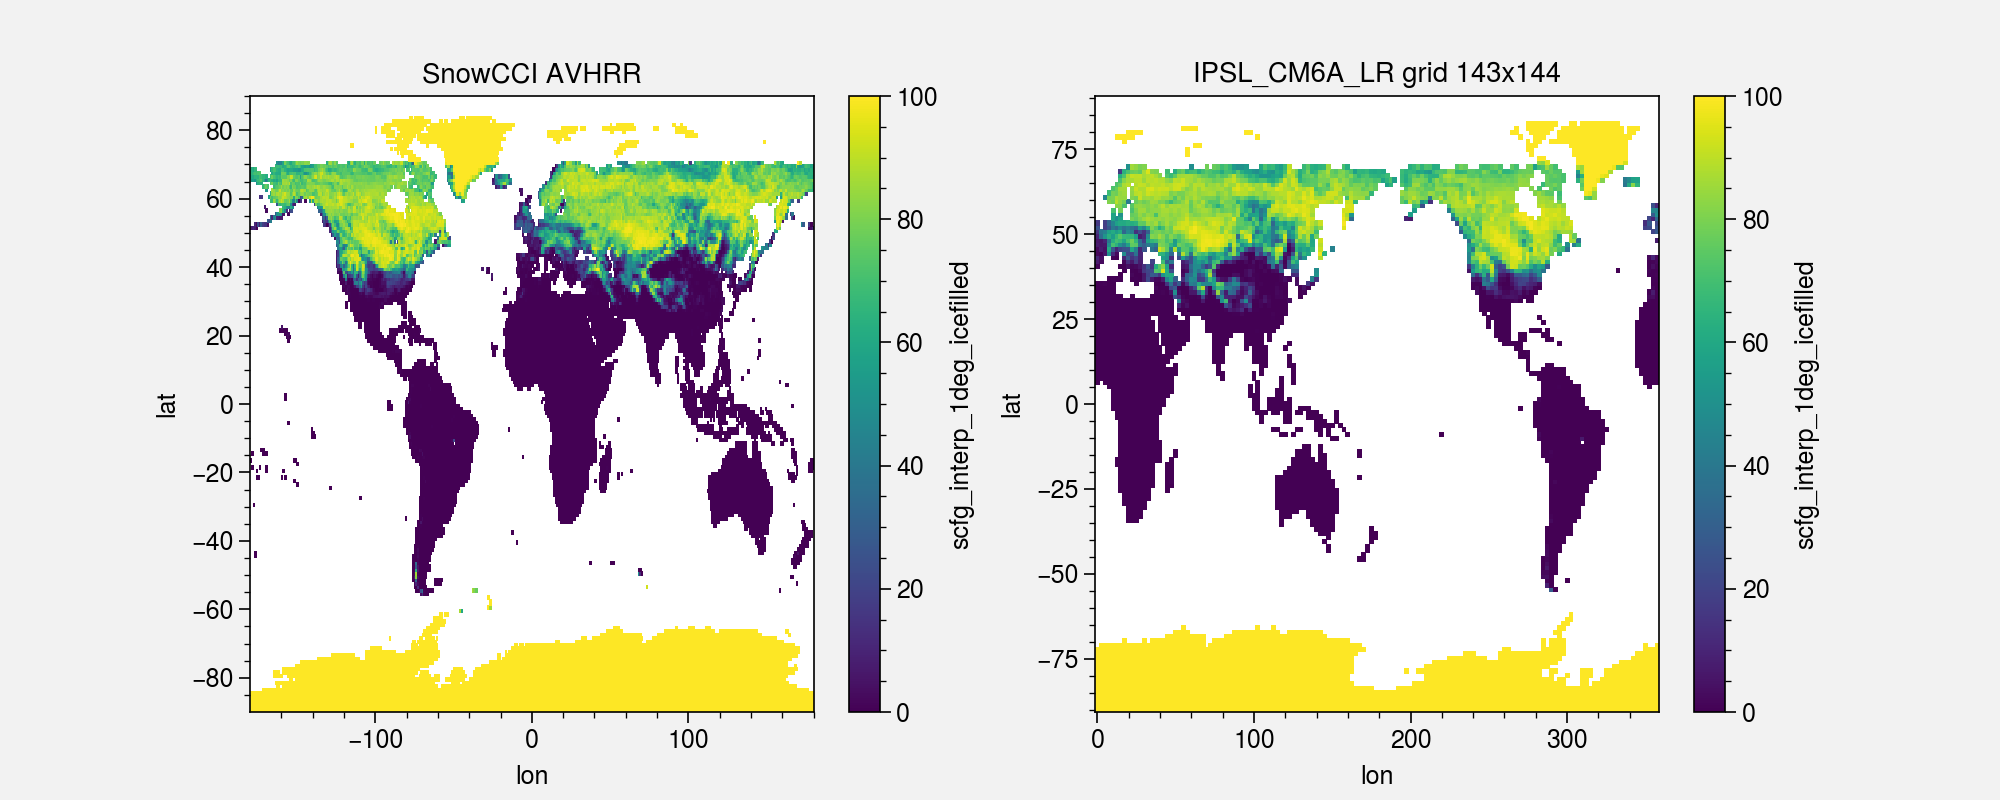

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(121)
snow_cci_interp[0].plot()
plt.title('SnowCCI AVHRR')
plt.subplot(122)
snow_cci_interp_regrid[0].plot()
plt.title('IPSL_CM6A_LR grid 143x144')

## Annual Climatology

In [15]:
latlim=(10,50)
lonlim=(60,110)

da_historical_clim = u.clim(da_historical.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_historical_clim.load()

da_amip_clim = u.clim(da_amip.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_amip_clim.load()

da_land_hist_clim = u.clim(da_land_hist.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_land_hist_clim.load()

da_land_hist_cruNcep_clim = u.clim(da_land_hist_cruNcep.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_land_hist_cruNcep_clim.load()

da_HR_regrid_clim = u.clim(da_HR_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_HR_regrid_clim.load()

da_HR_clim = u.clim(da_HR.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
da_HR_clim.load()

obs_regrid_clim = u.clim(obs_regrid.sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1])))
obs_regrid_clim.load()

snow_cci_interp_clim = snow_cci_interp.groupby('time.month').mean().mean('month').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
snow_cci_interp_clim.load()

snow_cci_interp_regrid_clim = snow_cci_interp_regrid.groupby('time.month').mean().mean('month').sel(lat=slice(latlim[0],latlim[1]), lon=slice(lonlim[0],lonlim[1]))
snow_cci_interp_regrid_clim.load()

/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/data/mlalande/miniconda3/envs/phd_v3/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.DataArray 'scfg_interp_1deg_icefilled' (lat: 32, lon: 21)>
array([[           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 1.21415106e-01,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan, 1.80211785e-02,            nan,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan,            nan, 5.02731044e-02,
                   nan,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
                   nan,            nan, 1.63217721e-02, 5.98266994e-02,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan, 5.10212773e-02, 2.40724724e-02,
        4.30085916e-02,            nan,            nan,            nan,
                   nan,            nan,            nan,            nan,
        4.76621811e-02, 7.12489115e-02, 3.20910902e-02, 2.20092527e-02,
                   nan],
       [           nan,            nan,            nan,            nan,
                   nan,            nan, 3.06924706e-02, 1.51290218e-02,
...
        1.06155960e+01, 1.42932371e+01, 1.45722284e+01, 1.37977691e+01,
        1.64677762e+01],
       [2.40732558e+01, 2.29555931e+01, 2.37585481e+01, 2.57811363e+01,
        2.69986248e+01, 3.04194608e+01, 2.73539432e+01, 2.67566977e+01,
        2.93811698e+01, 3.09738563e+01, 2.46761089e+01, 2.93561682e+01,
        3.64006534e+01, 2.02652122e+01, 1.75922230e+01, 2.96445948e+01,
        2.43283665e+01, 2.18950723e+01, 2.12603910e+01, 2.47841211e+01,
        2.30498337e+01],
       [2.87207947e+01, 2.72762601e+01, 2.91465150e+01, 3.20466094e+01,
        3.23492155e+01, 3.46251097e+01, 3.46754957e+01, 3.38664176e+01,
        3.40753819e+01, 3.47265909e+01, 3.50600957e+01, 4.41778675e+01,
        3.23860312e+01, 1.61075117e+01, 2.38045971e+01, 4.17415535e+01,
        2.41420617e+01, 2.34447930e+01, 2.55828665e+01, 2.53564736e+01,
        2.19824196e+01],
       [3.34037905e+01, 3.13582179e+01, 3.26241843e+01, 3.61161916e+01,
        3.53065897e+01, 3.53622173e+01, 3.58807730e+01, 3.18709326e+01,
        3.35165949e+01, 3.66322740e+01, 4.58955588e+01, 5.48669606e+01,
        1.95458440e+01, 2.63154511e+01, 3.68809996e+01, 4.21804495e+01,
        1.81483817e+01, 1.77091199e+01, 2.35784137e+01, 2.26640817e+01,
        2.50872403e+01]])
Coordinates:
  * lon      (lon) float32 60.0 62.5 65.0 67.5 70.0 ... 102.5 105.0 107.5 110.0
  * lat      (lat) float32 10.140845 11.408451 12.676056 ... 48.169014 49.43662

In [17]:
# We remove HR for keeping the resolution

concat = xr.concat(
    [
        da_historical_clim,
        da_amip_clim,
        da_land_hist_clim,
    ],
    pd.Index(
        [
            'Historical (32)',
            'AMIP (21)',
            'land-hist (1)',
        ], 
        name='exp'
    )
)

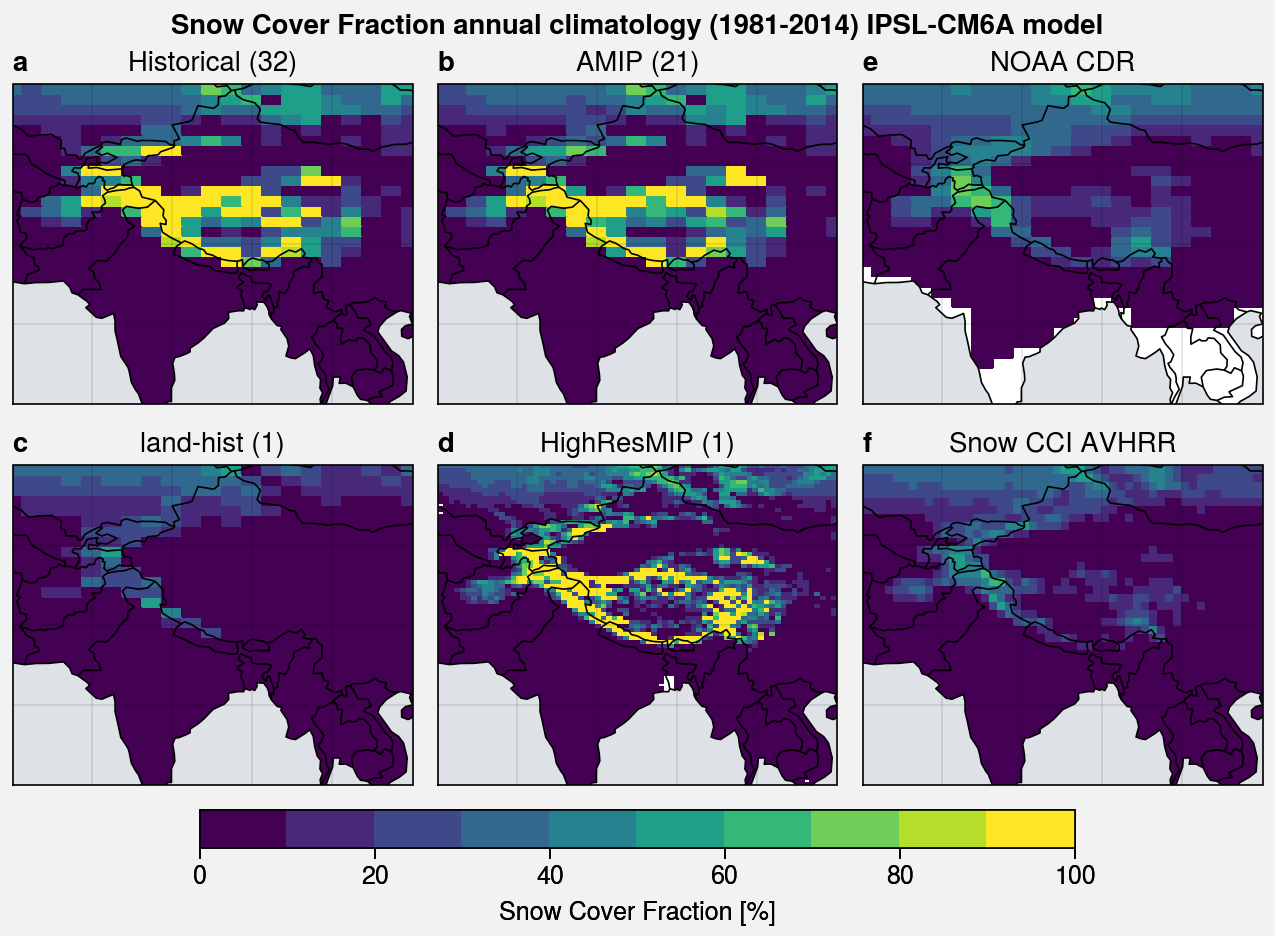

In [24]:
#Check colorbars 

f, axs = plot.subplots([[1, 2, 5], [3, 4, 6]], proj='cyl', share=3, axwidth=2)

for i, ax in enumerate(axs):
    if i < 3:
        m = ax.pcolormesh(concat.isel(exp=i), cmap=cmap, levels=levels)
        ax.format(title=str(concat.isel(exp=i).exp.values))
    
axs[3].pcolormesh(da_HR_clim, cmap=cmap, levels=levels)
axs[3].format(title='HighResMIP (1)') 

axs[4].pcolormesh(obs_regrid_clim, cmap=cmap, levels=levels)
axs[4].format(title=obs_name)

axs[5].pcolormesh(snow_cci_interp_clim, cmap=cmap, levels=levels)
axs[5].format(title='Snow CCI AVHRR')

f.colorbar(m, label='Snow Cover Fraction [%]', loc='b', length=0.7)

axs.format(
    labels=False, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Snow Cover Fraction annual climatology (1981-2014) IPSL-CM6A model",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/scf_clim_1981-2014_IPSL-CM6A_exp.jpg')

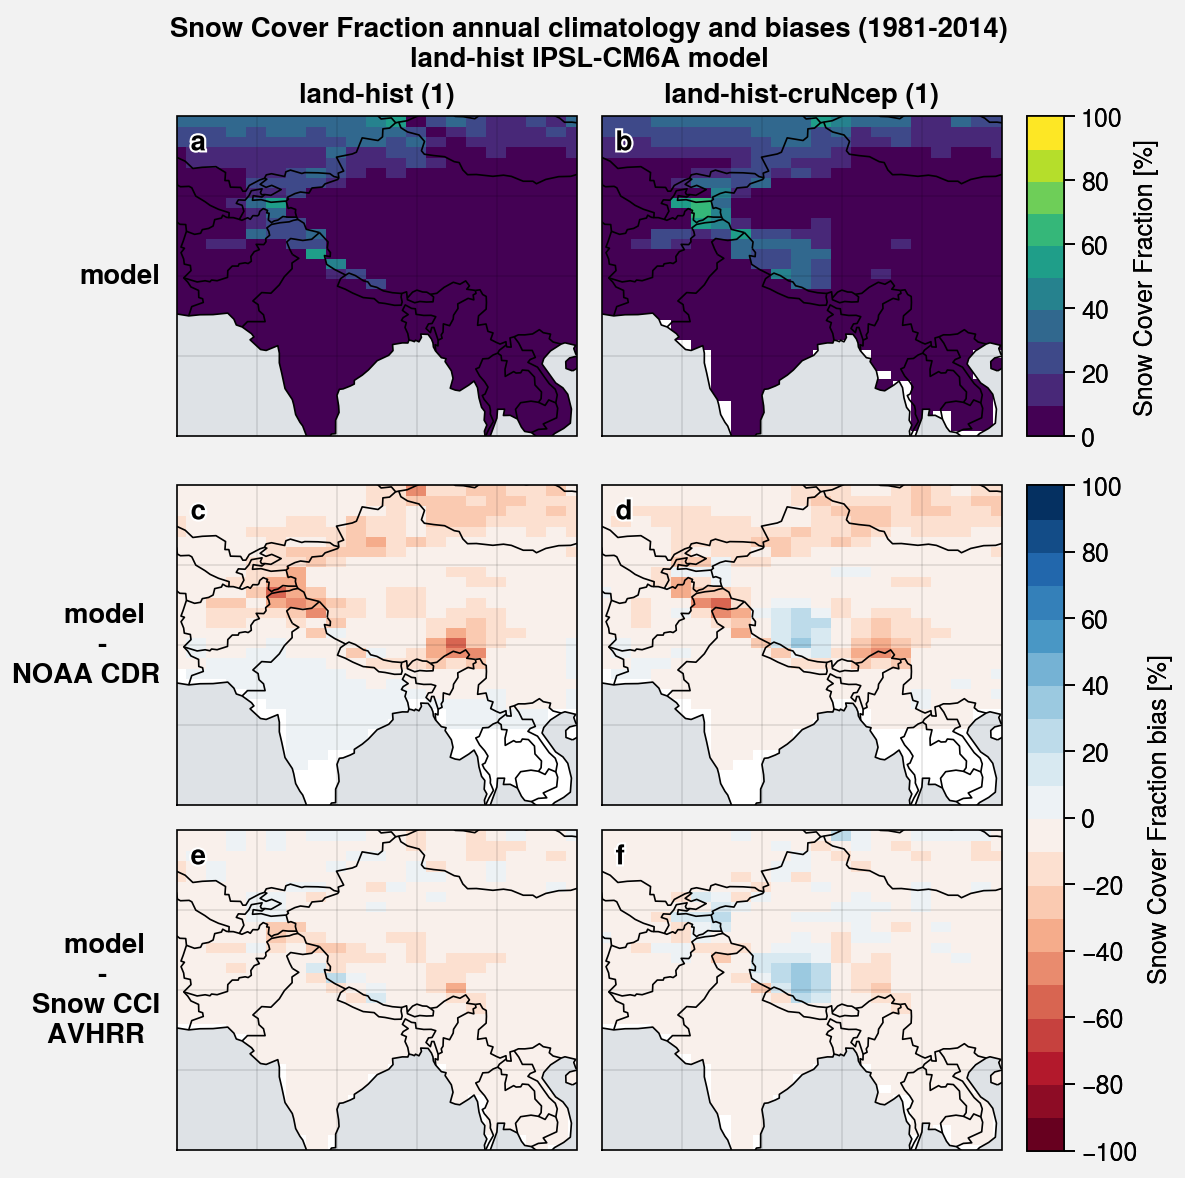

In [39]:
#Check colorbars 

f, axs = plot.subplots(ncols=2, nrows=3, proj='cyl', share=3, axwidth=2)
    
m = axs[0].pcolormesh(da_land_hist_clim, cmap=cmap, levels=levels)
axs[1].pcolormesh(da_land_hist_cruNcep_clim, cmap=cmap, levels=levels)

m2 = axs[2].pcolormesh(da_land_hist_clim - obs_regrid_clim, cmap='RdBu', levels=plot.arange(-100,100,10))
axs[3].pcolormesh(da_land_hist_cruNcep_clim - obs_regrid_clim, cmap='RdBu', levels=plot.arange(-100,100,10))

m2 = axs[4].pcolormesh(da_land_hist_clim - snow_cci_interp_regrid_clim, cmap='RdBu', levels=plot.arange(-100,100,10))
axs[5].pcolormesh(da_land_hist_cruNcep_clim - snow_cci_interp_regrid_clim, cmap='RdBu', levels=plot.arange(-100,100,10))


f.colorbar(m, label='Snow Cover Fraction [%]', row=1)
f.colorbar(m2, label='Snow Cover Fraction bias [%]', rows=(2,3))

axs.format(
    labels=False, coast=True, ocean=True, oceancolor='gray3', borders=True, abcloc='ul',
    suptitle="Snow Cover Fraction annual climatology and biases (1981-2014)\nland-hist IPSL-CM6A model",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim,
    collabels=['land-hist (1)', 'land-hist-cruNcep (1)'],
    rowlabels=['model', 'model  \n-       \nNOAA CDR', 'model  \n-       \nSnow CCI\nAVHRR  ']
)

f.save('img/scf_clim_1981-2014_land-hist_obs.jpg')

## Bias

In [40]:
bias = xr.concat(
    [
        (da_historical_clim-obs_regrid_clim),
        (da_amip_clim-obs_regrid_clim),
        (da_land_hist_clim-obs_regrid_clim),
        (da_HR_regrid_clim-obs_regrid_clim)
    ],
    pd.Index(
        [
            'Historical (32) - '+obs_name,
            'AMIP (21) - '+obs_name,
            'land-hist (1) - '+obs_name,
            'HighResMIP (1) - '+obs_name
        ], 
        name='bias'
    )
)

bias2 = xr.concat(
    [
        (da_historical_clim-snow_cci_interp_regrid_clim),
        (da_amip_clim-snow_cci_interp_regrid_clim),
        (da_land_hist_clim-snow_cci_interp_regrid_clim),
        (da_HR_regrid_clim-snow_cci_interp_regrid_clim)
    ],
    pd.Index(
        [
            'Historical (32) - Snow CCI AVHRR',
            'AMIP (21) - Snow CCI AVHRR',
            'land-hist (1) - Snow CCI AVHRR',
            'HighResMIP (1) - Snow CCI AVHRR'
        ], 
        name='bias'
    )
)

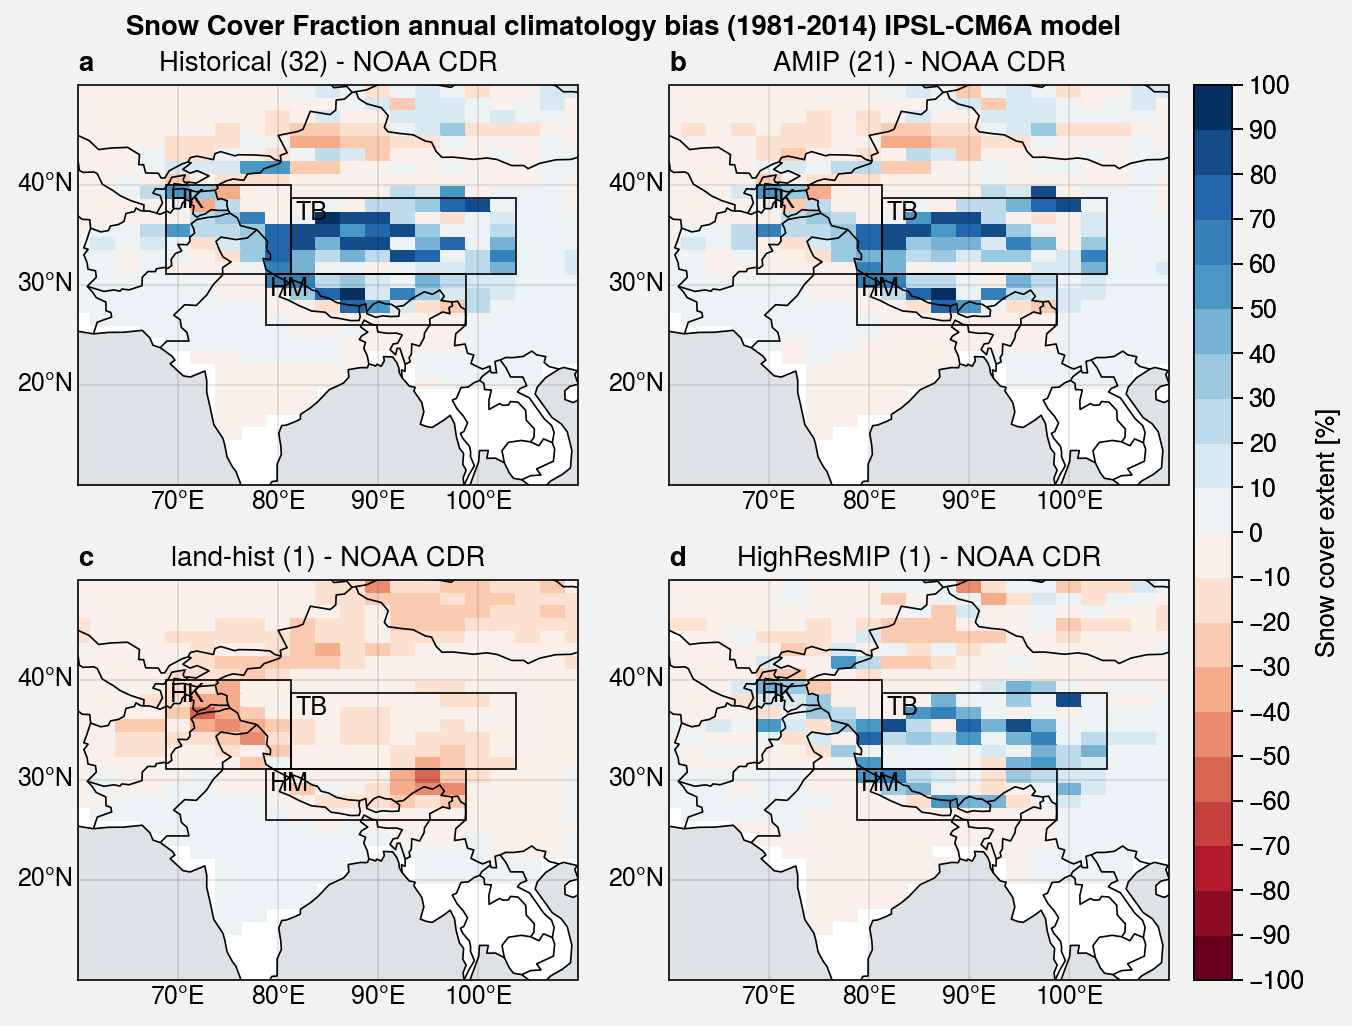

In [49]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=2.5)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias.isel(bias=i), 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
    )
    ax.format(title=str(bias.isel(bias=i).bias.values))

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Snow Cover Fraction annual climatology bias (1981-2014) IPSL-CM6A model",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/scf_clim_bias_1981-2014_IPSL-CM6A_NOAA-CDR.jpg')

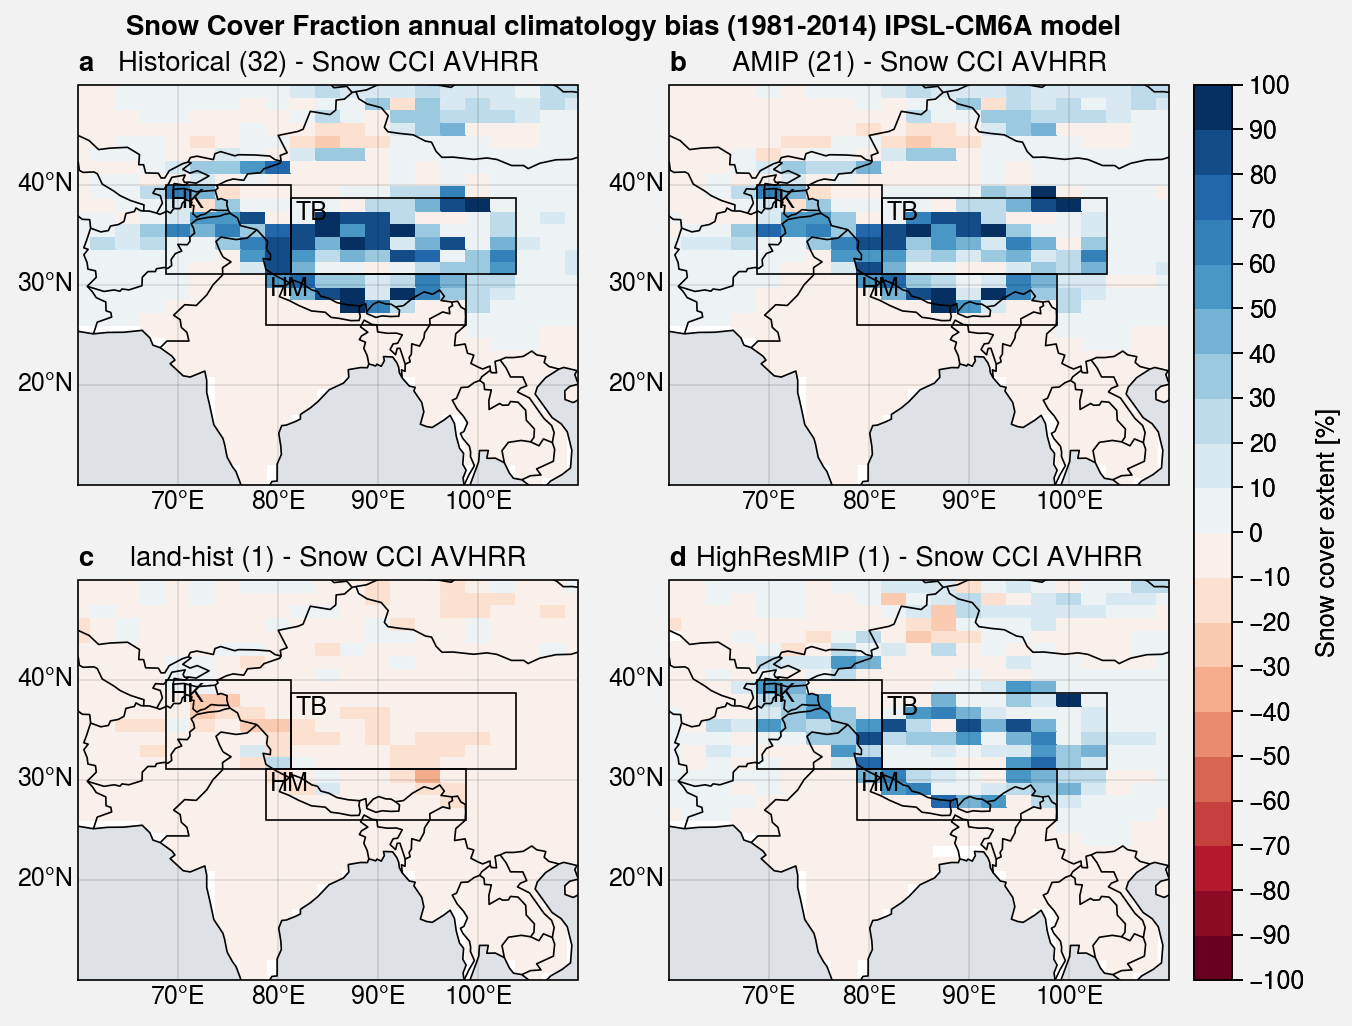

In [48]:
# Final plot

f, axs = plot.subplots(proj='cyl', ncols=2, nrows=2, share=3, axwidth=2.5)

for i, ax in enumerate(axs):
    m = ax.pcolormesh(
        bias2.isel(bias=i), 
        cmap='RdBu', 
        levels=plot.arange(-100,100,10), 
    )
    ax.format(title=str(bias2.isel(bias=i).bias.values))

f.colorbar(m, label=var_label)

# Add boxes
for ax in axs:
    u.plot_zones_IPSL_CM6A_LR(ax)

axs.format(
    labels=True, coast=True, ocean=True, oceancolor='gray3', borders=True,
    suptitle="Snow Cover Fraction annual climatology bias (1981-2014) IPSL-CM6A model",
    lonlines=10, latlines=10, abc=True, latlim=latlim, lonlim=lonlim
)

f.save('img/scf_clim_bias_1981-2014_IPSL-CM6A_Snow-CCI-AVHRR.jpg')

# Annual cycle on the different zones

In [33]:
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TB, latlim_TB = u.get_zones_IPSL_CM6A_LR()

# # Old single zone
# # lonlim_zone=(78,78+20)
# # latlim_zone=(27,27+11)

# dx=2.5
# dy=1.2676

# lonlim_WH=(70-dx/2,70-dx/2+10)
# latlim_WH=(31.690142-dy/2+dy,31.690142-dy/2+dy+7.6056339+dy)

# lonlim_CH=(77.5-dx/2+dx,77.5-dx/2+dx+15)
# latlim_CH=(26.619719-dy/2,26.619719-dy/2+3.802816)

# lonlim_TB=(82.5-dx/2-dx,82.5-dx/2-dx+15+2*dx)
# latlim_TB=(31.690142-dy/2-dy,31.690142-dy/2-dy+7.6056339)

In [13]:
lonlim_HK, latlim_HK, lonlim_HM, latlim_HM, lonlim_TB, latlim_TB = u.get_zones_IPSL_CM6A_LR()

titles = ['HK', 'HM', 'TB']
zone_slices = [
    [slice(lonlim_HK[0],lonlim_HK[1]), slice(latlim_HK[0],latlim_HK[1])],
    [slice(lonlim_HM[0],lonlim_HM[1]), slice(latlim_HM[0],latlim_HM[1])],
    [slice(lonlim_TB[0],lonlim_TB[1]), slice(latlim_TB[0],latlim_TB[1])]
]

# Annual cycle r1i1p1f1

In [41]:
realization = 'r1i1p1f1'

# Load historical
da_historical_r1i1p1f1 = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/historical/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

# Load amip
da_amip_r1i1p1f1 = xr.open_mfdataset(
    '/bdd/CMIP6/CMIP/'+institute+'/'+model+'/amip/'+realization+'/'+table+'/'+var+'/gr/latest/*.nc', combine='by_coords'
).sel(time=period)[var]

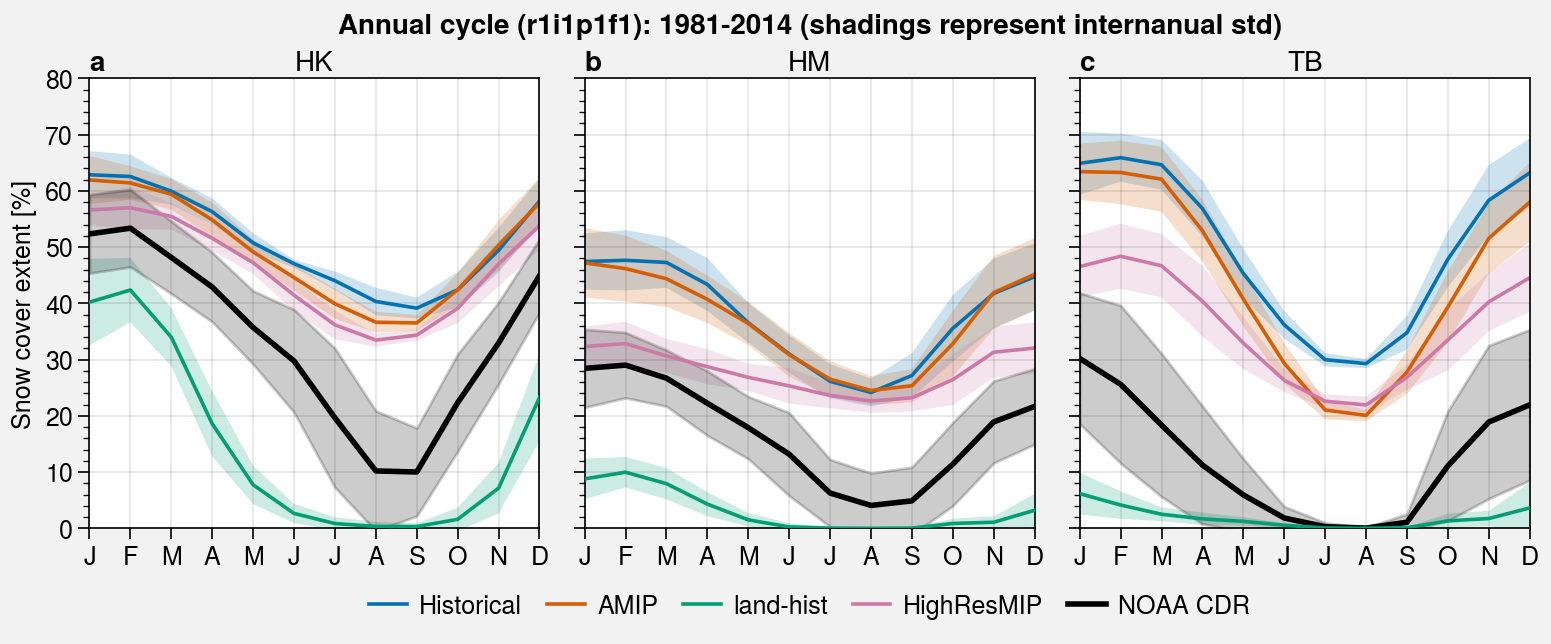

In [32]:
f, axs = plot.subplots(ncols=3, nrows=1)

for i, ax in enumerate(axs):
    
    # Compute annual cycles on the zone
    # Ensemble
    sa_historical_r1i1p1f1 = u.spatial_average(
        da_historical_r1i1p1f1.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )
    sa_amip_r1i1p1f1 = u.spatial_average(
        da_amip_r1i1p1f1.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )

    # Not ensemble
    sa_land_hist = u.spatial_average(
        da_land_hist.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )
    sa_obs_regrid = u.spatial_average(
        obs_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )
    sa_HR_regrid = u.spatial_average(
        da_HR_regrid.sel(lon=zone_slices[i][0], lat=zone_slices[i][1])
    )
    
    
    # historical
    y = sa_historical_r1i1p1f1.groupby('time.month').mean()
    x = y.month
    std = sa_historical_r1i1p1f1.groupby('time.month').std()
    h1 = y.plot(ax=ax, label='Historical')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    
    # amip
    y = sa_amip_r1i1p1f1.groupby('time.month').mean()
    x = y.month
    std = sa_amip_r1i1p1f1.groupby('time.month').std()
    h2 = y.plot(ax=ax, label='AMIP')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    
    # land_hist
    y = sa_land_hist.groupby('time.month').mean()
    x = y.month
    std = sa_land_hist.groupby('time.month').std()
    h3 = y.plot(ax=ax, label='land-hist', zorder=10)
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    
    # HighResMIP
    y = sa_HR_regrid.groupby('time.month').mean()
    x = y.month
    std = sa_HR_regrid.groupby('time.month').std()
    h4 = y.plot(ax=ax, label='HighResMIP')
    ax.fill_between(x, y-std, y+std, alpha=0.2)
    
    # Obs
    y = sa_obs_regrid.groupby('time.month').mean()
    x = y.month
    std = sa_obs_regrid.groupby('time.month').std()
    h5 = y.plot(ax=ax, label=obs_name, color='black', linewidth=2)
    ax.fill_between(x, y-std, y+std, alpha=0.2, color='black')
    
    
    h6 = ac_era_regrid.plot(ax=ax, label='ERA-Interim', color='dark', linestyle='--')
    
    ax.format(title=titles[i])
    hs = [h1, h2, h3, h4, h5]

axs.format(
    xlocator='index', xformatter=['J','F','M','A','M','J','J','A','S','O','N','D'], xtickminor=False,
    xlabel='', ylabel=var_label,
    suptitle='Annual cycle (r1i1p1f1): 1981-2014 (shadings represent internanual std)', abc=True,
    ylim=(0,80)
)
    
f.legend(hs, loc='b', ncols=5, order='F', center=False, frame=False)

# f.save('img/'+var+'/ac_r1i1p1f1_zones_'+var+'.png')
# f.save('img/'+var+'/ac_r1i1p1f1_zones_'+var+'.pdf')

## Monthly bias global